# Logistic Map

Tutorial created by Wilson Rocha

## The Logistic Map

Chaotic systems are deterministic processes that exhibit unpredictable, seemingly random behavior due to their extreme sensitivity to initial conditions. Though governed by simple rules, these systems are notoriously difficult to model over long timescales, making them a fascinating challenge for system identification. The Logistic Map is a classic example of chaos, first popularized in ecology to model population growth. Its simple equation,

$$
x_{n+1} = r x_n (1 - x_n)
$$

captures a rich variety of behaviors, from stable equilibria to periodic oscillations and full chaos, depending on the growth parameter $r$. By studying this system, we gain insights into universal phenomena like the period-doubling route to chaos and the emergence of fractal structures in bifurcation diagrams. In this tutorial, we’ll use SysIdentPy to model the Logistic Map and reconstruct its bifurcation diagram, showcasing how data-driven approaches can capture chaotic dynamics.

## Visualizing the Logistic Map

To understand the Logistic Map, let’s first visualize its behavior across different regimes of $r$:

- **Stable Fixed Points $r < 3$**: For low $r$, the population converges to a steady value.
- **Periodic Regimes $3 < r < 3.57$**: As $r$ increases, the system undergoes period-doubling bifurcations, oscillating between 2, 4, 8, … states.
- **Chaos $r \geq 3.57$**: Beyond the accumulation point, the system behaves chaotically, with trajectories never repeating.

A **cobweb plot** helps visualize the iteration process: starting from an initial $x_0$, we alternate between evaluating the Logistic Map (vertical jumps) and updating $x_n$ (horizontal moves to the diagonal). Chaotic regimes show erratic, non-repeating cobweb patterns, while periodic regimes trace stable cycles.

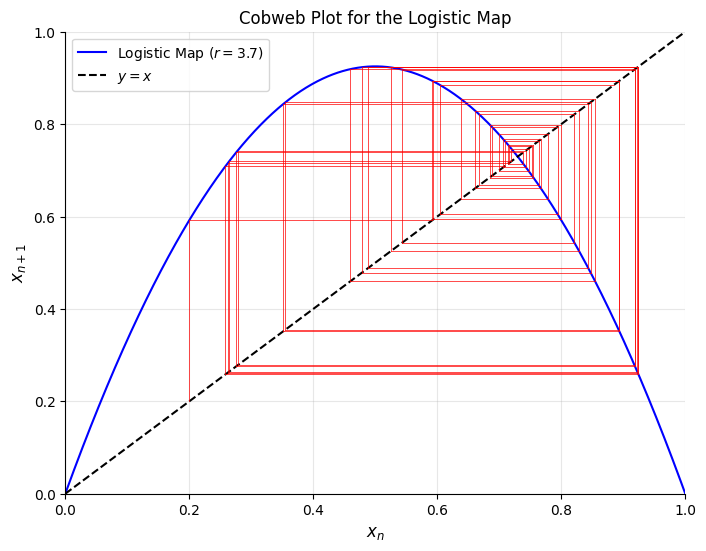

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares

from sysidentpy.utils.plotting import plot_results
from sysidentpy.utils.display_results import results


def logistic_map(x, r):
    """Compute one iteration of the logistic map."""
    return r * x * (1 - x)


# Parameters
r = 3.7  # Growth rate (try 2.8, 3.2, 3.5, 3.9)
n_iter = 50  # Number of iterations
x0 = 0.2  # Initial condition

# Create cobweb plot
x = np.linspace(0, 1, 1000)
f = logistic_map(x, r)

plt.figure(figsize=(8, 6))
plt.plot(x, f, "b-", label=f"Logistic Map ($r={r}$)")
plt.plot(x, x, "k--", label="$y = x$")

# Simulate iterations
xt = np.zeros(n_iter)
xt[0] = x0
for i in range(n_iter - 1):
    y = logistic_map(xt[i], r)
    plt.plot([xt[i], xt[i]], [xt[i], y], "r", lw=0.5)  # Vertical line
    plt.plot([xt[i], y], [y, y], "r", lw=0.5)  # Horizontal line
    xt[i + 1] = y

plt.xlabel("$x_n$", fontsize=12)
plt.ylabel("$x_{n+1}$", fontsize=12)
plt.title("Cobweb Plot for the Logistic Map")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

The plot above shows the Logistic Curve (Blue). The diagonal line (Black Dashed) represents $x_{n+1} = x_n$ and shows the intersections with the logistic curve indicate fixed points. Finally, the vertical lines of the Cobweb trajectory (in red) apply the map $x_n \to x_{n+1}$ and the horizontal lines reset $x_n = x_{n+1}$ for the next iteration.

The interpretation by regime can be taken as follows:

- Stable Fixed Point (e.g., $r = 2.8$):
  The cobweb spirals inward to a single point.

- Periodic (e.g., $r = 3.5$):
  The trajectory cycles between 4 points (period-4).

- Chaotic (e.g., $r = 3.9$):
  The red lines never repeat, filling the space erratically.

### **3. Generating the Bifurcation Diagram**

The bifurcation diagram summarizes how the Logistic Map’s long-term behavior changes with $r$. We will create it considering:
1. Sweeping $r$ across a range ($3.5 \leq r \leq 4.0$).
2. Iterate the map: For each $r$, discard transient iterations (first 500 steps) to focus on asymptotic behavior.
3. Plot $x$ for the remaining iterations.

The bifurcation diagram reveals several key features. Period-doubling cascades occur as successive bifurcations split stable points into pairs, leading to progressively longer periods. Chaotic regions emerge as dense bands of points, indicating a high sensitivity to initial conditions. Within these chaotic regimes, windows of order appear, such as near $r \approx 3.83$, where periodic behavior temporarily reemerges, highlighting the subtle structure underlying chaos.

This diagram serves as a “fingerprint” of the system, which we’ll later reconstruct using SysIdentPy models.

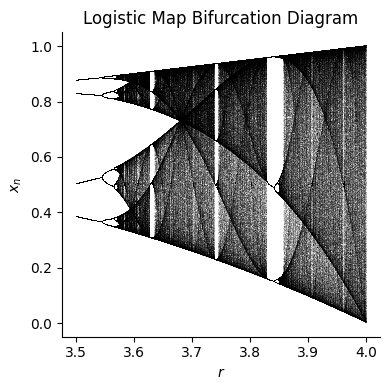

In [2]:
num = 1000
N = 1000
N_drop = 500
r0 = 3.5

rs = r0 + np.arange(num) / num * (4 - r0)
xss = []

# Generate bifurcation data
for r in rs:
    x = 0.5  # Initial condition
    xs = []

    # Warmup iterations (discard transient)
    for _ in range(N_drop):
        x = logistic_map(x, r)

    # Store stable iterations
    for _ in range(N):
        x = logistic_map(x, r)
        xs.append(x)

    xss.append(xs)

plt.figure(figsize=(4, 4), dpi=100)
for r, xs in zip(rs, xss):
    plt.plot([r] * len(xs), xs, ",", alpha=0.1, c="black", rasterized=True)

plt.xlabel("$r$")
plt.ylabel("$x_n$")
plt.title("Logistic Map Bifurcation Diagram")
plt.tight_layout()
plt.show()

Let's start by building a model for the logistic map with $r = 3.5$ to evaluate how SysIdentPy performs in this periodic scenario.

  Regressors   Parameters             ERR
0          1  -2.4433E-14  9.05069788E-01
1   y(k-1)^3   3.6415E-14  9.17450154E-02
2     y(k-1)   3.5000E+00  3.13396079E-03
3   y(k-1)^2  -3.5000E+00  5.12359326E-05


c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:621: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4
  self.info_values = self.information_criterion(reg_matrix, y)


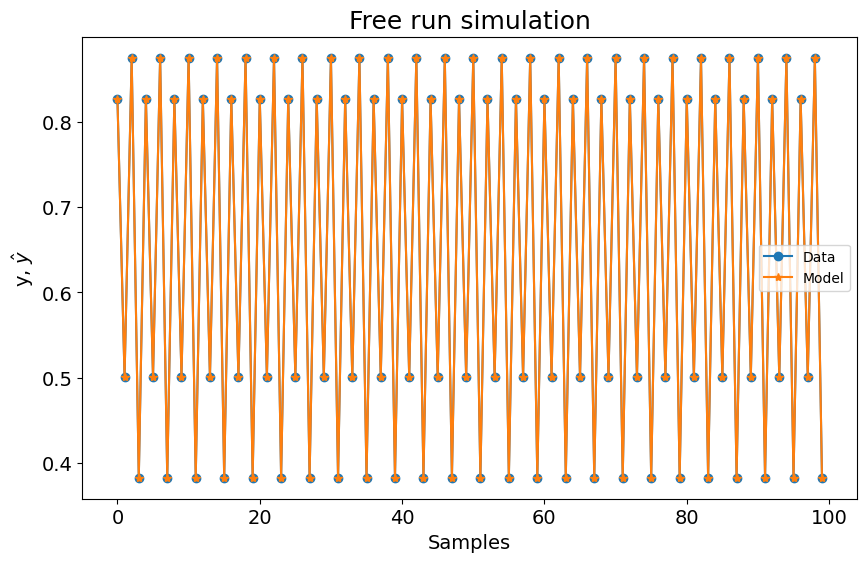

In [3]:
y = np.array(xss[0]).reshape(-1, 1)
y_train = y[:800, :].copy()
y_test = y[200:, :].copy()

basis_function = Polynomial(degree=3)
model = FROLS(
    ylag=1,
    estimator=LeastSquares(),
    basis_function=basis_function,
    model_type="NAR",
)
model.fit(y=y_train)
yhat = model.predict(y=y_test[:2].reshape(-1, 1), forecast_horizon=len(y_test))

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_test[model.max_lag :], yhat=yhat[model.max_lag :])

### **5. Reconstructing the Bifurcation Diagram with Models**

Can a data-driven model like NARMAX replicate the Logistic Map’s bifurcation behavior? Let’s find out:

The following steps will be executed:

1. Loop over $r$: For each value in the range (e.g., 2.5 to 4.0 in steps of 0.01).
2. Train a model: Generate synthetic data for the current $r$, split into training/testing sets, and fit a NARMAX model using SysIdentPy’s `FROLS` algorithm.
3. Prediction: Use the trained model to predict future states, starting from an initial condition.
4. Plot: Collect the asymptotic states and overlay them on a bifurcation diagram.

c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:621: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 4
  self.info_values = self.information_criterion(reg_matrix, y)
c:\Users\wilso\miniconda3\envs\sysidentpyv04\Lib\site-packages\sysidentpy\parameter_estimation\estimators.py:75: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  self._check_linear_dependence_rows(psi)


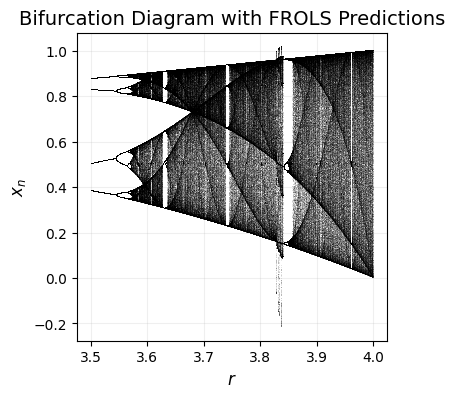

In [4]:
def fit_model(y_train, y_test, degree=3, ylag=1, n_info_values=50):
    """Fit a NARX model and return predictions."""
    basis_function = Polynomial(degree=degree)
    model = FROLS(
        ylag=ylag,
        n_info_values=n_info_values,
        estimator=LeastSquares(),
        basis_function=basis_function,
        model_type="NAR",
    )
    model.fit(y=y_train)
    return model.predict(
        y=y_test[: model.max_lag].reshape(-1, 1), forecast_horizon=len(y_test)
    )


def generate_bifurcation_data(rs, N, N_drop):
    """Generate logistic map data and model predictions for each r."""
    xss, yhat_bifurcation = [], []
    for r in rs:
        x = 0.5
        # Warm-up iterations
        for _ in range(N_drop):
            x = logistic_map(x, r)

        # Stable iterations (corrected loop)
        xs = []
        for _ in range(N):
            x = logistic_map(x, r)
            xs.append(x)

        xss.append(xs)

        # Prepare data for modeling
        y = np.array(xs).reshape(-1, 1)
        y_train, y_test = y[:800, :], y[200:, :]
        yhat = fit_model(y_train, y_test)
        yhat_bifurcation.append(np.array(yhat))

    return xss, yhat_bifurcation


# Parameters
num = 1000
N, N_drop = 1000, 500
r0 = 3.5
rs = r0 + np.arange(num) / num * (4 - r0)

xss, yhat_bifurcation = generate_bifurcation_data(rs, N, N_drop)

# Plot predicted bifurcation diagram
plt.figure(figsize=(4, 4), dpi=100)
for ind, r in enumerate(rs):
    plt.plot(
        [r] * len(yhat_bifurcation[ind]),
        yhat_bifurcation[ind],
        ",",
        alpha=0.1,
        c="black",
        rasterized=True,
    )

plt.title("Bifurcation Diagram with FROLS Predictions", fontsize=14)
plt.xlabel("$r$", fontsize=12)
plt.ylabel("$x_n$", fontsize=12)
plt.grid(alpha=0.2)
plt.show()


As shown in the plots above, the models accurately reproduce stable cycles in periodic regimes, with minimal prediction errors. In chaotic regimes, the models provide accurate short-term predictions, but long-term divergence occurs due to the sensitivity to initial conditions, highlighting the inherent limitations of chaotic system modeling. The generated bifurcation diagram retains the key features, such as period-doubling and chaotic transitions, although finer details may require a model with higher complexity. This experiment demonstrates SysIdentPy’s ability to capture essential nonlinear dynamics, even in chaotic scenarios.